##### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2025 Semester 1

## Assignment 1: Scam detection with naive Bayes


**Student ID(s):**     `1455881`


This iPython notebook is a template which you will use for your Assignment 1 submission.

**NOTE: YOU SHOULD ADD YOUR RESULTS, GRAPHS, AND FIGURES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).** Results, figures, etc. which appear in this file but are NOT included in your report will not be marked.

**Adding proper comments to your code is MANDATORY. **

## 1. Supervised model training


In [1468]:
import numpy as np
import pandas as pd
import os
import sys
import math
from math import factorial, log
from functools import reduce
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from scipy.stats import entropy


In [1469]:
def read_csv(file_path):
    
    # Check if the file path is valid
    if not os.path.exists(file_path):
        print(f"ERROR: File not found: {file_path}")
        sys.exit(1)

    try:
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        print(f"ERROR: Failed to read the CSV file: {e}")
        sys.exit(1)

In [1470]:
# read the input file
file_path = "sms_supervised_train.csv"
df = read_csv(file_path)

print(df.head())

                                        textOriginal  \
0                       So u workin overtime nigpun?   
1  Also sir, i sent you an email about how to log...   
2  Ok lor. Anyway i thk we cant get tickets now c...   
3                                 Wat r u doing now?   
4  Is there a reason we've not spoken this year? ...   

                                    textPreprocessed  class  
0                                         ? u workin      0  
1  . . .. sir , send send email log payment ll an...      0  
2  ? . . 2 4 u quite get ok lor anyway thk ticket...      0  
3                                          ? u wat r      0  
4   ? great reason speak year anyways week good exam      0  


In [1471]:
def create_vocabulary(data):
    """
    Extracts a list of unique words from the 'textPreprocessed' column of the dataset.
    Used to build the vocabulary for feature extraction.
    """
    words = " ".join(data['textPreprocessed'].fillna('').astype(str)).split()
    vocabulary, _ = np.unique(words, return_counts=True)
    vocabulary = list(vocabulary)
    return vocabulary

In [1472]:
def create_count(data, vocab):
    """
    Creates a count matrix (N x V) where each row represents a message and each column
    corresponds to a word in the vocabulary. Each cell contains the frequency of the word in that message.
    """
    N = len(data)
    V = len(vocab)
    count= np.zeros((N, V), dtype=int)
    total = 0

    for i, text in enumerate(data['textPreprocessed'].fillna('').astype(str)):
        for word in text.split():
            if word in vocab:
                j = vocab.index(word)
                count[i, j] += 1
                total += 1
    
    return count

In [1473]:
def create_matrix (data):
    """
    Generates a count matrix DataFrame from preprocessed text data, using the vocabulary
    extracted from the 'textPreprocessed' column. Also appends the class label.
    
    Returns:
        vocabulary (list): List of unique words.
        count_df (DataFrame): Word count matrix with class labels.
    """
    vocabulary = create_vocabulary(data)
    count_df = pd.DataFrame(create_count(data, vocabulary), columns=vocabulary)

    try:
        if "class_label" in vocabulary:
            raise ValueError("The column name 'class_label' is already in use in the vocabulary. Please use a different name for the class column.")
        count_df['class_label'] = df['class']
    except ValueError as e:
        print(e)

    return vocabulary, count_df

In [1474]:
def calc_prior(df):
    """
    Calculates the prior probabilities P(class) for each class in the dataset.
    """
    class_counts = df['class_label'].value_counts()
    N = len(df)
    priors = {}
    for c, count in class_counts.items():
        priors[c] = count / N
    return priors


In [1475]:
def word_likelihood_with_smoothing(data):
    """
    Computes the Laplace-smoothed likelihood P(word | class) for each word and class.
    """
    
    # Create an empty dictionary to store the likelihoods
    word = {}
    labels = data['class_label']
    unique_labels = np.unique(labels)
    features_list = [col for col in data.columns if col != 'class_label']
    total_sum = 0
    alpha = 1

    for feature in features_list:
        
        # Create a nested dictionary for each feature
        word[feature] = {}

        for label in unique_labels:
            # Create a nested dictionary for each label
            word[feature][label] = {}

            count = data[(data["class_label"] == label)][feature].sum()
            total_count = data[data["class_label"] == label][features_list].sum(axis=1).sum()

            # laplace smoothing
            total_count += alpha*len(features_list)
            count += alpha

            word[feature][label] = count / total_count
            total_sum += count / total_count
            #print(f"Likelihood of {feature} given label {label} is {word[feature][label]:.4f}")
    #print(total_sum)
    return word

In [1476]:
def train_model(count_df):
    """
    Trains a Naive Bayes model by computing class priors and word likelihoods
    with Laplace smoothing from the given count matrix.
    """

    # Calculate prior probabilities
    prior_prob = calc_prior(count_df)

    # Calculate likelihoods
    likelihood = word_likelihood_with_smoothing(count_df)

    return prior_prob, likelihood

In [1477]:
# Train the Naive Bayes model on the full labeled dataset
vocabulary, count_df = create_matrix(df)
priors_prob, likelihood = train_model(count_df)

print("Priors:", priors_prob)
print("likelihood:", likelihood)

Priors: {0: 0.8, 1: 0.2}
likelihood: {'!': {0: 0.017187325047587056, 1: 0.024350472877486682}, '"': {0: 0.005598477214197738, 1: 0.0007609522774214588}, '#': {0: 0.0053745381256298285, 1: 0.0006522448092183933}, '$': {0: 0.00044787817713581906, 1: 0.0007609522774214588}, '%': {0: 0.00016795431642593214, 1: 0.0008696597456245244}, '&': {0: 0.013100436681222707, 1: 0.008696597456245243}, "'": {0: 0.003918934049938417, 1: 0.0011957821502337211}, "'ll": {0: 0.0006158324935617512, 1: 0.00010870746820306555}, "'m": {0: 0.00011196954428395476, 1: 0.00010870746820306555}, "'re": {0: 0.0003359086328518643, 1: 0.00010870746820306555}, "'s": {0: 0.0052065838092038965, 1: 0.0018480269594521143}, "'ve": {0: 5.598477214197738e-05, 1: 0.00097836721382759}, '(': {0: 0.000727802037845706, 1: 0.00391346885531036}, ')': {0: 0.0013436345314074571, 1: 0.00391346885531036}, '*': {0: 0.0030231776956667787, 1: 0.007065985433199261}, '+': {0: 0.0005598477214197738, 1: 0.004022176323513425}, ',': {0: 0.02603291

In [1478]:
# Prior Probability display
prior_df = pd.DataFrame.from_dict(priors_prob, orient='index', columns=['Value'])
prior_df.reset_index(inplace=True)
prior_df.columns = ['class', 'Prior Probability P(C)']
display(prior_df)

,class,Prior Probability P(C)
0,0,0.8
1,1,0.2


In [1523]:
def show_top_words_per_class(likelihood, top_n=10):
    """
    Displays the top N most probable words for each class based on the likelihoods.
    """
    class_words = {}

    # Group (word, probability) pairs by class
    for word, probs in likelihood.items():
        for label, prob in probs.items():
            if label not in class_words:
                class_words[label] = []
            class_words[label].append((word, prob))

    # Sort and display top N words for each class
    for label in sorted(class_words.keys()):
        print(f"\nTop {top_n} Probable Words for Class '{int(label)}'")
        sorted_words = sorted(class_words[label], key=lambda x: x[1], reverse=True)
        top_words = pd.DataFrame(sorted_words[:top_n], columns=['Word', 'Probability'])
        display(top_words)

In [1480]:
show_top_words_per_class(likelihood, top_n=10)


Top 10 Probable Words for Class '0'


,Word,Probability
0,.,0.079330
1,",",0.026033
2,?,0.025585
3,u,0.018923
4,...,0.018755
5,!,0.017187
6,..,0.014948
7,;,0.013156
8,&,0.013100
9,go,0.011141



Top 10 Probable Words for Class '1'


,Word,Probability
0,.,0.056528
1,!,0.024350
2,",",0.023481
3,call,0.020546
4,£,0.013915
5,free,0.010545
6,/,0.009131
7,2,0.008805
8,&,0.008697
9,?,0.008479


In [1481]:
def show_most_predictive_words(likelihood, top_n=10):
    """
    Displays the top N most predictive words for each class based on the likelihood ratio R = P(word|1) / P(word|0).
    """
    ratios = []

    # Compute ratio R = P(word|1) / P(word|0) for each word
    for word, probs in likelihood.items():
        p0 = probs.get(0, 1e-10)  # Avoid division by zero
        p1 = probs.get(1, 1e-10)
        ratio = p1 / p0
        ratios.append((word, ratio))

    # Sort by ratio to find most predictive words
    top_scams = sorted(ratios, key=lambda x: x[1], reverse=True)[:top_n]
    top_non_malicious = sorted(ratios, key=lambda x: x[1])[:top_n]

    # Display top predictors for SCAM class
    print(f"\nTop {top_n} Most Predictive Words for SCAM Class (class 1)")
    df_scam = pd.DataFrame(top_scams, columns=["Word", "R (p1/p0)"])
    display(df_scam)

    # Display top predictors for NON-MALICIOUS class
    print(f"\nTop {top_n} Most Predictive Words for NON-MALICIOUS Class (class 0)")
    df_non_mal = pd.DataFrame(top_non_malicious, columns=["Word", "R (p1/p0)"])
    display(df_non_mal)

In [1482]:
show_most_predictive_words(likelihood, top_n=10)


Top 10 Most Predictive Words for SCAM Class (class 1)


,Word,R (p1/p0)
0,prize,99.028373
1,tone,64.077182
2,£,49.708360
3,select,46.601587
4,claim,45.954343
5,paytm,36.892923
6,code,34.951190
7,award,32.038591
8,won,31.067725
9,18,29.125992



Top 10 Most Predictive Words for NON-MALICIOUS Class (class 0)


,Word,R (p1/p0)
0,;,0.016525
1,...,0.017389
2,gt,0.018493
3,lt,0.018671
4,:),0.020879
5,ü,0.031318
6,lor,0.034674
7,hope,0.040453
8,ok,0.040453
9,d,0.047359


In [1483]:
def calc_posterior_with_smoothing(data, prior_prob, word_probs):
    """
    Calculates log posterior probabilities for each instance using the Multinomial Naive Bayes model
    with Laplace smoothing and log-space operations for numerical stability.
    """
    posterior_probs = []
    classes = prior_prob.keys()
    alpha = 1

    for _, instance in data.iterrows():
        x_vector = instance.to_dict()
        n = sum(x_vector.values())
 
        # Precompute factorials for multinomial coefficient
        # Log multinomial coefficient
        # applying gamma function math.lgamma(n + 1) gives log(factorial(n)) without computing the factorial directly
        log_multinomial_coeff = math.lgamma(n + 1) - sum(
            math.lgamma(x + 1) for x in x_vector.values() if x > 0
        )

        post_probs = {}

        for label in classes:
            log_prob = math.log(prior_prob[label]) + log_multinomial_coeff

            for word, x_i in x_vector.items():
                if x_i == 0:
                    continue

                # Get smoothed P(word | class)
                p_c_i = word_probs.get(word, {}).get(label, None)
                if p_c_i is None:
                    # If somehow missing, apply Laplace smoothing manually
                    V = len(word_probs)
                    p_c_i = alpha / (alpha * V)
                    #print the misssing value:
                    #print("mission value with smoothing:", word)

                #print("word:", word)
                #print("pci:",p_c_i)

                # Add log(P(word|class)^count) = count * log(P)
                log_prob += x_i * math.log(p_c_i)

            post_probs[label] = log_prob

        posterior_probs.append(post_probs)

    return posterior_probs

In [ ]:
def predict_test_with_smoothing(data, prior_prob, likelihood):
    # Calculate posterior log-probabilities
    posterior_probs = calc_posterior_with_smoothing(data, prior_prob, likelihood)

    # Find the class with the highest log-probability
    argmax_labels = [max(post, key=post.get) for post in posterior_probs]
    return argmax_labels, posterior_probs

## 2. Supervised model evaluation

In [1485]:
# read the test file
test_path = "sms_test.csv"
test_df = read_csv(test_path)

In [1486]:
# Generate word count matrix for the test set using the test vocabulary
test_vocabulary = create_vocabulary(test_df)
test_count = pd.DataFrame(create_count(test_df, test_vocabulary), columns = test_vocabulary)
test_count

,!,"""",#,$,%,&,','ll,'m,'re,...,yun,yup,zed,|,,£,ü,–,…,�
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1487]:
def calc_accuracy(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    correct = int(accuracy * len(true_labels))
    total = len(true_labels)
    
    print("correct predict:", correct)
    print("total test:", total)
    return accuracy

In [1488]:
# Run prediction on the test set using the trained model
# Calculate and print prediction accuracy
predictions, posterior_probs = predict_test_with_smoothing(test_count, priors_prob, likelihood)
true_labels = test_df['class'].tolist()
accuracy = calc_accuracy(predictions, true_labels)
print("Accuracy:", accuracy)

correct predict: 975
total test: 1000
Accuracy: 0.975


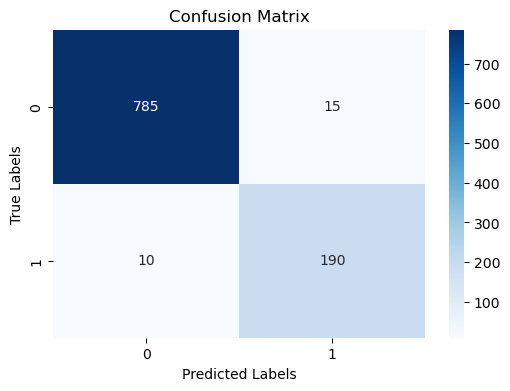


Classification Report:
              precision    recall  f1-score   support

           0     0.9874    0.9812    0.9843       800
           1     0.9268    0.9500    0.9383       200

    accuracy                         0.9750      1000
   macro avg     0.9571    0.9656    0.9613      1000
weighted avg     0.9753    0.9750    0.9751      1000



In [1489]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Precision, Recall, F1-Score
print("\nClassification Report:")
print(classification_report(true_labels, predictions, digits=4))

In [1490]:
# out-of-vocabulary words in the test set
def new_vocab(vocab1, vocab2):
    new_words = set(vocab1) - set(vocab2)
    if new_words:
        print("New words not in training vocabulary:")
        print(new_words)
        print("Number of new words:")
        print(len(new_words))
    else:
        print("All test vocabulary words are present in the training vocabulary.")


In [1491]:
new_vocab(test_vocabulary, vocabulary)

New words not in training vocabulary:
{'possession', 'title', 'bet', 'infernal', 'esplanade', 'fromm', 'trouble', 'skype', '://', 'activity', 'pg', '0845', 'armand', 'realise', 'ru', '81151', 'dreams', 't-mobile', 'law', 'piece', 'boston', 'ec2a', 'oz', 'daddy', 'empty', 'lecture', 'sup', 'definitely', 'feelin', '2nite', 'nyc', 'fyi', 'legal', 'annoying', 'prabha', 'postcode', 'require', 'aiyar', 'realy', '87131', 'market', '=d', 'girlfrnd', 'gram', 'grl', 'mini', '32', 'fee', 'dick', 'holla', 'nearly', 'pie', 'fetch', 'fault', 'manage', 'pack', 'report', '0578', 'asleep', 'calling', 'journey', 'rally', 'hmv', 'ta', 'cancer', 'k.', '6hrs', 'inside', 'experience', 'harry', 'wed', 'greet', 'sen', 'woke', 'depend', '7250i', 'yijue', 'hook', 'drivin', 'befor', 'exactly', 'lay', 'lift', 'yahoo', 'lmao', 'din', 'affair', '1956669', 'challenge', 'plot', 'wet', 'act', 'fire', 'bud'}
Number of new words:
94


In [1528]:
def is_unknown_only_row(data, word_probs):
    """
    Identifies rows in the dataset that contain only words not seen during training.
    Also counts the total number of word occurrences not in word_probs.
    """
    unknown_rows = []
    unknown_word_count = 0

    for idx, x_vector in data.iterrows():
        all_missing = True
        for word, x_i in x_vector.items():
            if x_i == 0:
                continue
            if word not in word_probs:
                unknown_word_count += x_i  # Count how many times the unknown word appears
            else:
                all_missing = False
        if all_missing:
            unknown_rows.append(idx)

    return unknown_rows, unknown_word_count

In [1530]:
# Display skipped items
skipped_items, unknown_count = is_unknown_only_row(test_count, likelihood)
print(skipped_items)
print("oov total count:", unknown_count)

[]
oov total count: 179


In [1494]:
def predict_confidence(test_df, posterior_probs, prediction, class1=0, class2=1):
    """
    Computes prediction confidence and probability ratios (R = P(class2) / P(class1))
    for each test instance using log-space posterior probabilities.
    """
    results = []

    for i, post_probs in enumerate(posterior_probs):
        log_prob_c0 = post_probs[class1]
        log_prob_c1 = post_probs[class2]

        # Convert log probs to actual probs via softmax normalization (optional but more accurate)
        max_log = max(log_prob_c0, log_prob_c1)
        prob_c0 = math.exp(log_prob_c0 - max_log)
        prob_c1 = math.exp(log_prob_c1 - max_log)

        R = prob_c1 / prob_c0
        predicted_class = prediction[i]
        actual_class = test_df.iloc[i]['class'] if 'class' in test_df.columns else None
        original_text = test_df.iloc[i]['textPreprocessed'] if 'textPreprocessed' in test_df.columns else None

        results.append({
            'textPreprocessed': original_text,
            'predicted_class': predicted_class,
            'actual_class': actual_class,
            f'{class1}_prob (convert from log)': prob_c0,
            f'{class2}_prob (convert from log)': prob_c1,
            'R': R
        })

    # Convert to DataFrame if it's a list of dicts
    if isinstance(results, list):
        result_df = pd.DataFrame(results)


    return result_df

In [1495]:
def show_confidence_examples(result_df, class0='0', class1='1'):
    """
    Extracts high-confidence and low-confidence prediction examples from the results.
    """
    result_df = result_df.copy()
    
    # Ensure consistent string types
    result_df['predicted_class'] = result_df['predicted_class'].astype(str)
    result_df['actual_class'] = result_df['actual_class'].astype(str)

    # Compute distance from R = 1
    result_df['R_diff_from_1'] = (result_df['R'] - 1).abs()

    # Get top examples by confidence
    high_conf_class1 = result_df[result_df['predicted_class'] == class1].sort_values('R', ascending=False)
    high_conf_class0 = result_df[result_df['predicted_class'] == class0].sort_values('R', ascending=True)
    near_boundary = result_df.sort_values('R_diff_from_1')

    # Drop helper column
    high_conf_class1.drop(columns=['R_diff_from_1'], inplace=True)
    high_conf_class0.drop(columns=['R_diff_from_1'], inplace=True)
    near_boundary.drop(columns=['R_diff_from_1'], inplace=True)

    # Return the three subsets
    return high_conf_class1, high_conf_class0, near_boundary

In [1526]:
# Get top examples as dataframes
results_df = predict_confidence(test_df, posterior_probs, predictions)
high_conf_class1_df, high_conf_class0_df, boundary_df = show_confidence_examples(results_df)

print("scam with high confidence")
display(high_conf_class1_df.head(3))
print("\nnon-malicious with high confidence")
display(high_conf_class0_df.head(3))
print("\nboundary between the two classes")
display(boundary_df.head(3))

scam with high confidence


,textPreprocessed,predicted_class,actual_class,0_prob (convert from log),1_prob (convert from log),R
844,. 4 + call £ - * holiday & urgent 18 t landlin...,1,1,7.426503e-21,1.0,1.346529e+20
985,. 3 4 + ! call : £ offer * holiday & urgent 18...,1,1,7.815483e-21,1.0,1.279511e+20
460,". . . , please order text call / : customer to...",1,1,8.763776e-21,1.0,1.141061e+20



non-malicious with high confidence


,textPreprocessed,predicted_class,actual_class,0_prob (convert from log),1_prob (convert from log),R
341,time : rs. transaction number & & & & & & & & ...,0,0,1.0,1.084297e-38,1.084297e-38
223,"? ? ? ? .. .. u u u u , , ... ... ... ... say ...",0,0,1.0,3.670796e-30,3.670796e-30
969,. every & & & & & & ; ; ; ; ; ; lt lt lt # # #...,0,0,1.0,3.123974e-26,3.123974e-26



boundary between the two classes


,textPreprocessed,predicted_class,actual_class,0_prob (convert from log),1_prob (convert from log),R
90,. call dear,0,0,1.000000,0.982520,0.982520
455,. reply glad,0,0,1.000000,0.957099,0.957099
767,. . tell return re order,1,0,0.931034,1.000000,1.074075


## 3. Extending the model with semi-supervised training

In [1497]:
# Read unlabelled file
unlabel_path = "sms_unlabelled.csv"
unlabel_df = read_csv(unlabel_path)

##### Baseline model using ramdom sampling for the 200 instances

In [1498]:
# baseline: random sampling 
# Randomly sample from unlabelled data
sampled = unlabel_df.sample(n=200, random_state=32)
_, sampled_count = create_matrix(sampled)
baseline_train_data = pd.concat([count_df,sampled_count])
baseline_train_data = baseline_train_data.fillna(0)
baseline_train_data = baseline_train_data.astype(int)
baseline_train_data = baseline_train_data.loc[:, (baseline_train_data != 0).any(axis=0)]

baseline_train_data

,!,"""",#,$,%,&,','ll,'m,'re,...,peace,pg,piece,postcode,require,taunton,title,trouble,wet,yahoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1499]:
def cross_validate_model(data, k=5):
    """
    Performs 3-fold cross-validation on the given labeled count matrix.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []

    for train_index, val_index in kf.split(data):
        # Split data
        train_data = data.iloc[train_index]
        val_data = data.iloc[val_index]

        # Train the model on training fold
        priors, likelihood = train_model(train_data)

        # Predict on validation fold
        predictions, _ = predict_test_with_smoothing(val_data, priors, likelihood)

        # Get true labels
        true_labels = val_data['class_label']

        # Evaluate accuracy
        acc = calc_accuracy(predictions, true_labels)
        accuracies.append(acc)

    avg_accuracy = np.mean(accuracies)
    print(f"{k}-fold cross-validation accuracy: {avg_accuracy:.4f}")
    return avg_accuracy

In [1500]:
cross_validate_model(baseline_train_data)

correct predict: 418
total test: 440
correct predict: 411
total test: 440
correct predict: 411
total test: 440
correct predict: 416
total test: 440
correct predict: 417
total test: 440
5-fold cross-validation accuracy: 0.9423


0.9422727272727272

In [1501]:
# train the new semi-supervised model
base_priors_prob, base_likelihood = train_model(baseline_train_data)

print("Baseline Priors:", base_priors_prob)
print("Baseline likelihood:", base_likelihood)

Baseline Priors: {0: 0.7990909090909091, 1: 0.2009090909090909}
Baseline likelihood: {'!': {0: 0.017600976701597316, 1: 0.024274840567784405}, '"': {0: 0.0051887272357310004, 1: 0.0013371734211067683}, '#': {0: 0.0051887272357310004, 1: 0.000720016457519029}, '$': {0: 0.0004578288737409706, 1: 0.000720016457519029}, '%': {0: 0.00020347949944043138, 1: 0.0008228759514503189}, '&': {0: 0.012920948214467392, 1: 0.008434478502365768}, "'": {0: 0.003815240614508088, 1: 0.001440032915038058}, "'ll": {0: 0.0006104384983212941, 1: 0.00010285949393128986}, "'m": {0: 0.00010173974972021569, 1: 0.00010285949393128986}, "'re": {0: 0.0003560891240207549, 1: 0.00030857848179386956}, "'s": {0: 0.005036117611150677, 1: 0.0019543303846945074}, "'ve": {0: 5.0869874860107844e-05, 1: 0.0009257354453816088}, '(': {0: 0.0007121782480415098, 1: 0.004114379757251594}, ')': {0: 0.001271746871502696, 1: 0.004114379757251594}, '*': {0: 0.002950452741886255, 1: 0.008331619008434479}, '+': {0: 0.000864787872621833

##### High-entropy selection

In [1502]:
def compute_entropy_scores(unlabelled_data, posterior_function, prior, likelihood):
    """
    Computes entropy scores for each unlabelled instance based on log posterior probabilities.
    """
    # Compute log posteriors using the trained model
    select_posterior_probs = posterior_function(unlabelled_data, prior, likelihood)

    entropy_values = []
    for probs in select_posterior_probs:
        log_prob_c0 = probs[0]
        log_prob_c1 = probs[1]

        # Convert log probs to actual probs via softmax normalization (optional but more accurate)
        max_log = max(log_prob_c0, log_prob_c1)
        prob_c0 = math.exp(log_prob_c0 - max_log)
        prob_c1 = math.exp(log_prob_c1 - max_log)

        # Create a distribution and compute entropy (base 2 = bits)
        summary_prob = {0: prob_c0, 1: prob_c1}
        entropy_val = entropy(list(summary_prob.values()), base=2)
        entropy_values.append(entropy_val)


    return pd.Series(entropy_values, index=unlabelled_data.index)

In [1503]:
def select_high_entropy_samples(unlabelled_data, entropy_scores, k=200):
    """
    Selects the top-k most uncertain instances based on entropy scores.
    """
    top_k_indices = entropy_scores.sort_values(ascending=False).head(k).index
    selected_df = unlabelled_data.loc[top_k_indices]
    return selected_df

In [1504]:
unlabel_vocabulary = create_vocabulary(unlabel_df)
unlabel_count = pd.DataFrame(create_count(unlabel_df, unlabel_vocabulary), columns = unlabel_vocabulary)

# Compute entropy
entropy_scores = compute_entropy_scores(unlabel_count, calc_posterior_with_smoothing, priors_prob, likelihood)

# Select top-k high-entropy samples
selected_entropy = select_high_entropy_samples(unlabel_count, entropy_scores, k=200)

In [1505]:
selected_entropy

,!,"""",#,$,%,&,','ll,'re,'s,...,zed,|,,¡,£,é,ü,–,…,�
929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
942,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1506]:
entropy_train_data = pd.concat([count_df,selected_entropy])

# Replace all NaN values with 0
entropy_train_data = entropy_train_data.fillna(0)
#entropy_train_data = entropy_train_data.astype(int)
entropy_train_data = entropy_train_data.loc[:, (entropy_train_data != 0).any(axis=0)]

entropy_train_data

,!,"""",#,$,%,&,','ll,'m,'re,...,experience,fyi,lecture,lmao,pie,piece,possession,proof,realise,santa
0,0,0,0,0,0,0,0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,0,0,0,0,0,0,0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,1,0,0,0,0,0,0,0,0.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1292,0,0,0,0,0,0,0,0,0.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
815,0,0,0,0,0,0,0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1507]:
cross_validate_model(entropy_train_data)

correct predict: 427
total test: 440
correct predict: 420
total test: 440
correct predict: 417
total test: 440
correct predict: 422
total test: 440
correct predict: 420
total test: 440
5-fold cross-validation accuracy: 0.9573


0.9572727272727274

In [1508]:
# train the new entropy_selected model
entropy_priors_prob, entropy_likelihood = train_model(entropy_train_data)

print("Entropy Priors:", entropy_priors_prob)
print("Entropy likelihood:", entropy_likelihood)

Entropy Priors: {0.0: 0.8181818181818182, 1.0: 0.18181818181818182}
Entropy likelihood: {'!': {0.0: 0.01787874007467003, 1.0: 0.024313470096602625}, '"': {0.0: 0.005416206552032392, 1.0: 0.000759795940518832}, '#': {0.0: 0.005048114844612715, 1.0: 0.0006512536633018561}, '$': {0.0: 0.0004206762370510596, 1.0: 0.000759795940518832}, '%': {0.0: 0.0002103381185255298, 1.0: 0.0008683382177358081}, '&': {0.0: 0.012620287111531788, 1.0: 0.008683382177358081}, "'": {0.0: 0.003891255192722301, 1.0: 0.0011939650493867362}, "'ll": {0.0: 0.000578429825945207, 1.0: 0.00010854227721697601}, "'m": {0.0: 0.0001051690592627649, 1.0: 0.00010854227721697601}, "'re": {0.0: 0.0003155071777882947, 1.0: 0.00010854227721697601}, "'s": {0.0: 0.005100699374244098, 1.0: 0.0018452187126885922}, "'ve": {0.0: 0.00015775358889414735, 1.0: 0.0009768804949527841}, '(': {0.0: 0.0008413524741021192, 1.0: 0.0039075219798111365}, ')': {0.0: 0.001419782300047326, 1.0: 0.0039075219798111365}, '*': {0.0: 0.00326024083714571

##### R confidence selection

In [1509]:
unlabel_predictions, unlabel_posterior_probs = predict_test_with_smoothing(unlabel_count, priors_prob, likelihood)
unlabel_confidence_df = predict_confidence(unlabel_df, unlabel_posterior_probs, unlabel_predictions)
_, _, unlabel_boundary_df = show_confidence_examples(unlabel_confidence_df)

In [1510]:
unlabel_boundary_df.drop(columns=['predicted_class','R','0_prob (convert from log)', '1_prob (convert from log)'], inplace=True)
unlabel_boundary_df.rename(columns={'actual_class': 'class'}, inplace=True)
confidence_selected = unlabel_boundary_df.head(200)
confidence_selected

,textPreprocessed,class
929,. country stamp,0
349,:) win win big luck,0
1495,win next number wot wine money,1
942,please,0
189,reply free free message get go right ! : just ...,1
...,...,...
344,. wife,0
768,. late call ill film,0
1611,. . . 2 .. buy urgent car wnt arrange vry urge...,0
511,yup,0


In [1511]:
_, confidence_count = create_matrix(confidence_selected)
confidence_train_data = pd.concat([count_df,confidence_count])
confidence_train_data = confidence_train_data.fillna(0)
confidence_train_data = confidence_train_data.astype(int)
confidence_train_data = confidence_train_data.loc[:, (confidence_train_data != 0).any(axis=0)]
confidence_train_data

,!,"""",#,$,%,&,','ll,'m,'re,...,experience,fyi,lecture,lmao,perfect,pie,piece,possession,proof,realise
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1512]:
cross_validate_model(confidence_train_data)

correct predict: 420
total test: 440
correct predict: 415
total test: 440
correct predict: 417
total test: 440
correct predict: 421
total test: 440
correct predict: 418
total test: 440
5-fold cross-validation accuracy: 0.9505


0.9504545454545456

## 4. Supervised model evaluation

In [1513]:
# baseline testing
base_predictions, _ = predict_test_with_smoothing(test_count, base_priors_prob, base_likelihood)
true_labels = test_df['class'].tolist()
accuracy = calc_accuracy(base_predictions, true_labels)
print("Baseline Accuracy:", accuracy)

correct predict: 976
total test: 1000
Baseline Accuracy: 0.976


In [1514]:
new_vocab(test_vocabulary, baseline_train_data.columns)

New words not in training vocabulary:
{'nearly', 'ec2a', 'yijue', 'oz', 'possession', 'pie', 'empty', 'hook', 'lecture', 'drivin', 'sup', 'feelin', 'fault', '2nite', 'nyc', 'bet', 'infernal', 'manage', 'annoying', 'esplanade', 'prabha', 'fromm', 'report', '0578', 'asleep', 'exactly', 'journey', 'lay', 'calling', 'skype', '://', 'aiyar', 'realy', 'rally', 'lmao', 'din', 'hmv', '0845', 'affair', 'ta', '1956669', 'cancer', '87131', '6hrs', 'armand', 'realise', '=d', 'girlfrnd', 'market', 'plot', 'ru', 'inside', 'grl', '81151', 'mini', 'dreams', 'experience', 't-mobile', 'law', 'act', 'wed', 'harry', 'greet', 'boston', 'sen', 'woke', 'dick', '7250i', 'fire', 'bud'}
Number of new words:
70


In [1534]:
# Display skipped items
base_skipped_items, base_unknown_count = is_unknown_only_row(test_count, base_likelihood)
print(base_skipped_items)
print("oov total count:", base_unknown_count)

[]
oov total count: 143


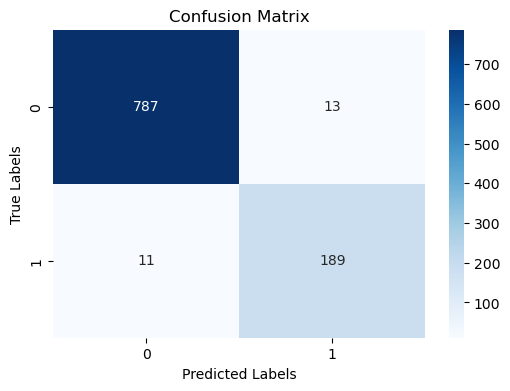


Classification Report:
              precision    recall  f1-score   support

           0     0.9862    0.9838    0.9850       800
           1     0.9356    0.9450    0.9403       200

    accuracy                         0.9760      1000
   macro avg     0.9609    0.9644    0.9626      1000
weighted avg     0.9761    0.9760    0.9760      1000



In [1516]:
# Confusion Matrix
cm = confusion_matrix(true_labels, base_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Precision, Recall, F1-Score
print("\nClassification Report:")
print(classification_report(true_labels, base_predictions, digits=4))

In [1536]:
# entropy testing
entropy_predictions, entropy_posterior_probs = predict_test_with_smoothing(test_count, entropy_priors_prob, entropy_likelihood)
true_labels = test_df['class'].tolist()
entropy_accuracy = calc_accuracy(entropy_predictions, true_labels)
print("With Entropy Accuracy:", entropy_accuracy)

correct predict: 980
total test: 1000
With Entropy Accuracy: 0.98


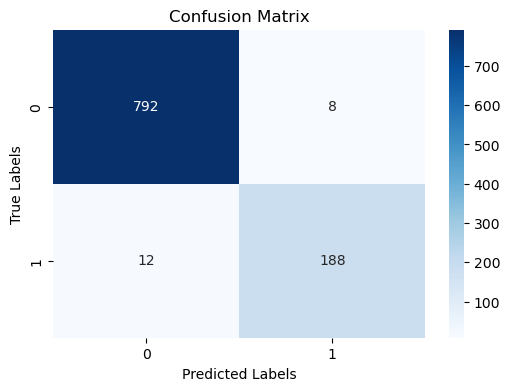


Classification Report:
              precision    recall  f1-score   support

           0     0.9851    0.9900    0.9875       800
           1     0.9592    0.9400    0.9495       200

    accuracy                         0.9800      1000
   macro avg     0.9721    0.9650    0.9685      1000
weighted avg     0.9799    0.9800    0.9799      1000



In [1518]:
# Confusion Matrix
cm = confusion_matrix(true_labels, entropy_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Precision, Recall, F1-Score
print("\nClassification Report:")
print(classification_report(true_labels, entropy_predictions, digits=4))

In [1519]:
new_vocab(test_vocabulary, entropy_train_data.columns)

New words not in training vocabulary:
{'title', 'bet', 'infernal', 'esplanade', 'fromm', 'trouble', 'skype', '://', 'activity', 'pg', '0845', 'armand', 'ru', '81151', 'dreams', 't-mobile', 'law', 'boston', 'ec2a', 'oz', 'daddy', 'empty', 'sup', 'definitely', 'feelin', '2nite', 'nyc', 'legal', 'annoying', 'prabha', 'postcode', 'require', 'aiyar', 'realy', '87131', 'market', '=d', 'girlfrnd', 'gram', 'grl', 'mini', '32', 'fee', 'dick', 'holla', 'nearly', 'fetch', 'fault', 'manage', 'pack', 'report', '0578', 'asleep', 'calling', 'journey', 'rally', 'hmv', 'ta', 'cancer', 'k.', '6hrs', 'inside', 'harry', 'wed', 'greet', 'sen', 'woke', '7250i', 'depend', 'yijue', 'hook', 'drivin', 'befor', 'exactly', 'lay', 'lift', 'yahoo', 'din', 'affair', '1956669', 'challenge', 'plot', 'wet', 'act', 'fire', 'bud'}
Number of new words:
86


In [1535]:
# Display skipped items
entropy_skipped_items, entropy_unknown_count = is_unknown_only_row(test_count, entropy_likelihood)
print(entropy_skipped_items)
print("oov total count:", entropy_unknown_count)

[]
oov total count: 165


In [1524]:
# Most probable words
show_top_words_per_class(entropy_likelihood, top_n=10)


Top 10 Probable Words for Class '0'


,Word,Probability
0,.,0.082084
1,",",0.026766
2,?,0.025609
3,u,0.018457
4,!,0.017879
5,...,0.017721
6,..,0.014145
7,&,0.012620
8,;,0.012463
9,go,0.010517



Top 10 Probable Words for Class '1'


,Word,Probability
0,.,0.056442
1,!,0.024313
2,",",0.023445
3,call,0.020514
4,£,0.013893
5,free,0.010529
6,/,0.009118
7,2,0.008792
8,&,0.008683
9,?,0.008466


In [1522]:
show_most_predictive_words(entropy_likelihood, top_n=10)


Top 10 Most Predictive Words for SCAM Class (class 1)


,Word,R (p1/p0)
0,prize,105.271573
1,tone,68.116900
2,select,49.539564
3,claim,48.851514
4,paytm,39.218821
5,£,37.744429
6,code,37.154673
7,won,33.026376
8,=,28.898079
9,mob,28.898079



Top 10 Most Predictive Words for NON-MALICIOUS Class (class 0)


,Word,R (p1/p0)
0,;,0.017419
1,...,0.018375
2,gt,0.019659
3,lt,0.019848
4,:),0.021728
5,ü,0.033293
6,lor,0.036860
7,hope,0.043003
8,ok,0.043003
9,d,0.050345


In [1545]:
def show_baseline_wrong_active_correct_with_confidence(
    base_preds, new_preds, true_labels,
    base_posteriors, new_posteriors,
    test_df, class0=0, class1=1):
    """
    Display instances where the baseline model made a wrong prediction,
    but the active learning model was correct. Includes confidence scores.
    """
    count = 0
    for i in range(len(true_labels)):
        base_pred = base_preds[i]
        active_pred = new_preds[i]
        true_label = true_labels[i]

        if base_pred != true_label and active_pred == true_label:
            count += 1

            # Extract confidence scores using R = P(class1) / P(class0)
            def compute_R(log_probs):
                log_c0 = log_probs[class0]
                log_c1 = log_probs[class1]
                max_log = max(log_c0, log_c1)
                p0 = math.exp(log_c0 - max_log)
                p1 = math.exp(log_c1 - max_log)
                return p1 / p0

            base_R = compute_R(base_posteriors[i])
            active_R = compute_R(new_posteriors[i])

            print(f"--- Instance #{i} ---")
            print(f"textPreprocessed: {test_df.iloc[i]['textPreprocessed'] if 'textPreprocessed' in test_df.columns else '[No Text]'}")
            print(f"Actual Class   : {true_label}")
            print(f"Base Prediction: {int(base_pred)} | Confidence R: {base_R:.4f}")
            print(f"Active Prediction: {int(active_pred)} | Confidence R: {active_R:.4f}")
            print("-" * 60)

    print(f"\n[SUMMARY] Found {count} instances where baseline was wrong but active model was correct.")

In [1546]:
show_baseline_wrong_active_correct_with_confidence(
    base_preds= predictions,
    new_preds= entropy_predictions,
    true_labels= true_labels,
    base_posteriors= posterior_probs,
    new_posteriors= entropy_posterior_probs,
    test_df= test_df
)

--- Instance #166 ---
textPreprocessed: . free / give otherwise
Actual Class   : 0
Base Prediction: 1 | Confidence R: 1.8036
Active Prediction: 0 | Confidence R: 0.9933
------------------------------------------------------------
--- Instance #409 ---
textPreprocessed: . . reply send person right ! code confirm sort bank acc
Actual Class   : 0
Base Prediction: 1 | Confidence R: 1.1307
Active Prediction: 0 | Confidence R: 0.7636
------------------------------------------------------------
--- Instance #463 ---
textPreprocessed: , text / confirm never answer g
Actual Class   : 0
Base Prediction: 1 | Confidence R: 1.3950
Active Prediction: 0 | Confidence R: 0.7344
------------------------------------------------------------
--- Instance #474 ---
textPreprocessed: @
Actual Class   : 0
Base Prediction: 1 | Confidence R: 1.2136
Active Prediction: 0 | Confidence R: 0.7645
------------------------------------------------------------
--- Instance #495 ---
textPreprocessed: up , 's hear text cal